In [1]:
import os
import numpy as np
import pandas as pd

from hmog import HmogHelper
from tqdm import tqdm

dataset_path = 'preprocessed_data/'

In [2]:
df = pd.read_csv(os.path.join(dataset_path, 'hmog_dataset_unified_df_ids_types_indices.csv'), index_col=0)
df_20s = pd.read_csv(os.path.join(dataset_path, 'hmog_dataset_unified_df_20s.csv'), index_col=0)
df_40s = pd.read_csv(os.path.join(dataset_path, 'hmog_dataset_unified_df_40s.csv'), index_col=0)
df_60s = pd.read_csv(os.path.join(dataset_path, 'hmog_dataset_unified_df_60s.csv'), index_col=0)
df_80s = pd.read_csv(os.path.join(dataset_path, 'hmog_dataset_unified_df_80s.csv'), index_col=0)
df_100s = pd.read_csv(os.path.join(dataset_path, 'hmog_dataset_unified_df_100s.csv'), index_col=0)
df_120s = pd.read_csv(os.path.join(dataset_path, 'hmog_dataset_unified_df_120s.csv'), index_col=0)
df_140s = pd.read_csv(os.path.join(dataset_path, 'hmog_dataset_unified_df_140s.csv'), index_col=0)

In [3]:
subjects_list = list(df['user_id'].unique())

train_negative_users = subjects_list[:10]
subjects_list = subjects_list[10:]

In [4]:
# Let's scale the data

from sklearn.preprocessing import StandardScaler

hmog_features = list(map(str, range(1, 65)))

scaler = StandardScaler()

df[hmog_features] = scaler.fit_transform(df[hmog_features])
df_20s[hmog_features] = scaler.transform(df_20s[hmog_features])
df_40s[hmog_features] = scaler.transform(df_40s[hmog_features])
df_60s[hmog_features] = scaler.transform(df_60s[hmog_features])
df_80s[hmog_features] = scaler.transform(df_80s[hmog_features])
df_100s[hmog_features] = scaler.transform(df_100s[hmog_features])
df_120s[hmog_features] = scaler.transform(df_120s[hmog_features])
df_140s[hmog_features] = scaler.transform(df_140s[hmog_features])

window_size_to_df = {20000: df_20s,
                     40000: df_40s,
                     60000: df_60s,
                     80000: df_80s,
                     100000: df_100s,
                     120000: df_120s,
                     140000: df_140s}

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def create_model():
    model = Sequential()
    model.add(Dense(60, input_shape=(64,), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [6]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

WINDOW_SIZES = [20000, 40000, 60000, 80000, 100000, 120000, 140000]

session_key_to_int = {'s': 0, 'w': 1}

def get_all_users_test_vectors(subject: int, session_type: str,  window_size: int):
    curr_df = window_size_to_df[window_size]
    test_hmog_vectors_all_users = curr_df[( (~(curr_df['user_id'] == subject) & (curr_df['user_id'].isin(subjects_list))) & (curr_df['session_type'] == session_key_to_int[session_type]) & (( curr_df['session_index'] == 2) | (curr_df['session_index'] == 3) ) )]
    test_hmog_vectors_all_users_np = test_hmog_vectors_all_users[hmog_features].to_numpy()
    return test_hmog_vectors_all_users_np

def get_user_test_vector(subject: int, session_type: str, window_size: int):
    curr_df = window_size_to_df[window_size]
    
    test_hmog_vector_positive = curr_df[( (curr_df['user_id'] == subject) & (curr_df['session_type'] == session_key_to_int[session_type]) & (( curr_df['session_index'] == 2) | (curr_df['session_index'] == 3) ) )]
    test_hmog_vector_positive_np = test_hmog_vector_positive[hmog_features].to_numpy()
    
    return test_hmog_vector_positive_np

def get_negative_train_df(users: set, session_type: str):
    return df[ ( ( df['user_id'].isin(users) ) & (df['session_type'] == session_key_to_int[session_type]) & ( (df['session_index'] == 0) | (df['session_index'] == 1) ))]

def test_eer(train_key: str, test_key: str, other_subjects_count: int):
    window_eers = {window_size: [] for window_size in WINDOW_SIZES}

    for i in tqdm(range(len(subjects_list))):
        subject = subjects_list[i]
        used_subjects = set()
        
        train_hmog_vector_positive = df[( (df['user_id'] == subject) & (df['session_type'] == session_key_to_int[train_key]) & ( (df['session_index'] == 0) | (df['session_index'] == 1) ) )]

        train_hmog_vector_negative = get_negative_train_df(set(train_negative_users[:other_subjects_count]), train_key)
        
        data = pd.concat([train_hmog_vector_positive, train_hmog_vector_negative], ignore_index=True)
        data.loc[data['user_id'] != subject, 'user_id'] = 0
        data.loc[data['user_id'] == subject, 'user_id'] = 1
        
        X, y = data[hmog_features], data['user_id']
        # print(X.shape, y.shape)
        # print(y.unique())
        
        model = create_model()
        model.fit(X, y, epochs=3, verbose=0)
        
        for window_size in WINDOW_SIZES:
            test_hmog_vector_positive_np = get_user_test_vector(subject, test_key, window_size)
            test_hmog_vectors_all_users_np = get_all_users_test_vectors(subject, test_key, window_size)
            
            predictions_self = model.predict(test_hmog_vector_positive_np, verbose=0)
            predictions_others = model.predict(test_hmog_vectors_all_users_np, verbose=0)
            
            scores = np.concatenate([predictions_self, predictions_others])
            
            y_true = [1] * len(predictions_self)
            y_true += ([0] * len(predictions_others))
            
            fpr, tpr, thresholds = roc_curve(y_true, scores)
    
            # Find the threshold where FPR equals FNR
            eer_index = np.argmin(np.abs(fpr - (1 - tpr)))
            eer = (fpr[eer_index] + (1 - tpr[eer_index])) / 2
    
            # Append EER to the list
            window_eers[window_size].append(eer)
    
    print(f'Count of negative users: {other_subjects_count}')
    for window_size in WINDOW_SIZES:
        window_eers[window_size] = np.mean(window_eers[window_size])
        print(f'Window size: {window_size / 1000}s\nPopulation EER: {window_eers[window_size]}')
    
    return window_eers

print('Done')

Done


In [7]:
neg_user_n = len(train_negative_users)
print(neg_user_n)
neg_user_eers = { count: {'ww': {}, 'ss': {}} for count in range(1, neg_user_n + 1) }

10


In [10]:
# import pickle
# 
# neg_user_eers = pickle.load(open('results/neg_user_eers_2.pkl', 'rb'))

In [8]:
def attempt(attempts, f, *args):
    if attempts == 0:
        return None
    try:
        return f(*args)
    except:
        return attempt(attempts - 1, f, *args)

In [9]:
import pickle

for i in range(1, neg_user_n + 1):
    neg_user_eers[i]['ww'] = attempt(3, test_eer, 'w', 'w', i)
    neg_user_eers[i]['ss'] = attempt(3, test_eer, 's', 's', i)
    pickle.dump(neg_user_eers, open(f'results/neg_user_eers_{i}.pkl', 'wb'))
    

100%|██████████| 82/82 [13:21<00:00,  9.78s/it]


Count of negative users: 1
Window size: 20.0s
Population EER: 0.1860631058170631
Window size: 40.0s
Population EER: 0.1806713687540179
Window size: 60.0s
Population EER: 0.17911830496288333
Window size: 80.0s
Population EER: 0.17766298329782354
Window size: 100.0s
Population EER: 0.17663883031254454
Window size: 120.0s
Population EER: 0.17573901893019092
Window size: 140.0s
Population EER: 0.17407865305842457


100%|██████████| 82/82 [12:59<00:00,  9.51s/it]


Count of negative users: 1
Window size: 20.0s
Population EER: 0.25386469383573157
Window size: 40.0s
Population EER: 0.2525869042036737
Window size: 60.0s
Population EER: 0.2516369175181999
Window size: 80.0s
Population EER: 0.25087000314704033
Window size: 100.0s
Population EER: 0.25008253152740106
Window size: 120.0s
Population EER: 0.2496856497605938
Window size: 140.0s
Population EER: 0.2489113314733662


100%|██████████| 82/82 [13:28<00:00,  9.85s/it]


Count of negative users: 2
Window size: 20.0s
Population EER: 0.17696576694970412
Window size: 40.0s
Population EER: 0.1729126515673026
Window size: 60.0s
Population EER: 0.1718705823841744
Window size: 80.0s
Population EER: 0.1707969339128108
Window size: 100.0s
Population EER: 0.16979744216643386
Window size: 120.0s
Population EER: 0.16937168459873936
Window size: 140.0s
Population EER: 0.168606075397547


100%|██████████| 82/82 [13:18<00:00,  9.74s/it]


Count of negative users: 2
Window size: 20.0s
Population EER: 0.2221365338279535
Window size: 40.0s
Population EER: 0.21871884145007678
Window size: 60.0s
Population EER: 0.21769667811174231
Window size: 80.0s
Population EER: 0.2175333142330375
Window size: 100.0s
Population EER: 0.21732681838340184
Window size: 120.0s
Population EER: 0.21684424211371695
Window size: 140.0s
Population EER: 0.21588367860431956


100%|██████████| 82/82 [13:37<00:00,  9.97s/it]


Count of negative users: 3
Window size: 20.0s
Population EER: 0.13382317719634065
Window size: 40.0s
Population EER: 0.12927441118174549
Window size: 60.0s
Population EER: 0.12751678972723274
Window size: 80.0s
Population EER: 0.1271103457633052
Window size: 100.0s
Population EER: 0.1264281719783426
Window size: 120.0s
Population EER: 0.12627147673209713
Window size: 140.0s
Population EER: 0.12599687793405143


100%|██████████| 82/82 [13:11<00:00,  9.66s/it]


Count of negative users: 3
Window size: 20.0s
Population EER: 0.1647361924442304
Window size: 40.0s
Population EER: 0.1617916131119173
Window size: 60.0s
Population EER: 0.16015744072680216
Window size: 80.0s
Population EER: 0.1593253139275265
Window size: 100.0s
Population EER: 0.15950082852926165
Window size: 120.0s
Population EER: 0.1589558328774713
Window size: 140.0s
Population EER: 0.15846486903191162


100%|██████████| 82/82 [13:27<00:00,  9.85s/it]


Count of negative users: 4
Window size: 20.0s
Population EER: 0.1455836359923667
Window size: 40.0s
Population EER: 0.14158339112594914
Window size: 60.0s
Population EER: 0.14046493233292826
Window size: 80.0s
Population EER: 0.13968799035755775
Window size: 100.0s
Population EER: 0.13932906297417572
Window size: 120.0s
Population EER: 0.13893922772371803
Window size: 140.0s
Population EER: 0.1387248592388965


100%|██████████| 82/82 [13:11<00:00,  9.65s/it]


Count of negative users: 4
Window size: 20.0s
Population EER: 0.1814894057139139
Window size: 40.0s
Population EER: 0.1794866905832757
Window size: 60.0s
Population EER: 0.17823343487142085
Window size: 80.0s
Population EER: 0.17759175177974706
Window size: 100.0s
Population EER: 0.17729097331604862
Window size: 120.0s
Population EER: 0.17675024428272634
Window size: 140.0s
Population EER: 0.17626878991159145


100%|██████████| 82/82 [13:29<00:00,  9.88s/it]


Count of negative users: 5
Window size: 20.0s
Population EER: 0.14279013938953983
Window size: 40.0s
Population EER: 0.13956868637067915
Window size: 60.0s
Population EER: 0.13820149062342021
Window size: 80.0s
Population EER: 0.1384030240894824
Window size: 100.0s
Population EER: 0.13777590159001168
Window size: 120.0s
Population EER: 0.13729393418959632
Window size: 140.0s
Population EER: 0.13707848807120177


100%|██████████| 82/82 [13:13<00:00,  9.68s/it]


Count of negative users: 5
Window size: 20.0s
Population EER: 0.18243396744527193
Window size: 40.0s
Population EER: 0.18052772126941866
Window size: 60.0s
Population EER: 0.17932284528848982
Window size: 80.0s
Population EER: 0.17914183475912243
Window size: 100.0s
Population EER: 0.17864873371596085
Window size: 120.0s
Population EER: 0.17855278456481388
Window size: 140.0s
Population EER: 0.17857781589646007


100%|██████████| 82/82 [13:30<00:00,  9.88s/it]


Count of negative users: 6
Window size: 20.0s
Population EER: 0.14196507213935752
Window size: 40.0s
Population EER: 0.13846964914729087
Window size: 60.0s
Population EER: 0.13771740169990598
Window size: 80.0s
Population EER: 0.1374332793464111
Window size: 100.0s
Population EER: 0.13662355640906965
Window size: 120.0s
Population EER: 0.13620991483168496
Window size: 140.0s
Population EER: 0.13593151066439924


100%|██████████| 82/82 [13:16<00:00,  9.72s/it]


Count of negative users: 6
Window size: 20.0s
Population EER: 0.17237866269427515
Window size: 40.0s
Population EER: 0.17088452140383417
Window size: 60.0s
Population EER: 0.17074109767864656
Window size: 80.0s
Population EER: 0.17057645577493713
Window size: 100.0s
Population EER: 0.17068200010232853
Window size: 120.0s
Population EER: 0.17001052195015887
Window size: 140.0s
Population EER: 0.16971094951071627


100%|██████████| 82/82 [13:38<00:00,  9.98s/it]


Count of negative users: 7
Window size: 20.0s
Population EER: 0.10488122131698435
Window size: 40.0s
Population EER: 0.10059713325267261
Window size: 60.0s
Population EER: 0.0989797883941741
Window size: 80.0s
Population EER: 0.09796918226893993
Window size: 100.0s
Population EER: 0.09698034848863563
Window size: 120.0s
Population EER: 0.09641692239052434
Window size: 140.0s
Population EER: 0.09551703229129536


100%|██████████| 82/82 [13:20<00:00,  9.76s/it]


Count of negative users: 7
Window size: 20.0s
Population EER: 0.15093753475649666
Window size: 40.0s
Population EER: 0.14857364481685148
Window size: 60.0s
Population EER: 0.1473707874272461
Window size: 80.0s
Population EER: 0.14681244490850018
Window size: 100.0s
Population EER: 0.1460606719564671
Window size: 120.0s
Population EER: 0.14515319307659444
Window size: 140.0s
Population EER: 0.14412973027642925


100%|██████████| 82/82 [13:38<00:00,  9.99s/it]


Count of negative users: 8
Window size: 20.0s
Population EER: 0.10478601294712411
Window size: 40.0s
Population EER: 0.10064168011800735
Window size: 60.0s
Population EER: 0.09909589368571677
Window size: 80.0s
Population EER: 0.09778313957651591
Window size: 100.0s
Population EER: 0.09712384386798655
Window size: 120.0s
Population EER: 0.09617792666009778
Window size: 140.0s
Population EER: 0.0956024050203525


100%|██████████| 82/82 [13:22<00:00,  9.78s/it]


Count of negative users: 8
Window size: 20.0s
Population EER: 0.15298851858350906
Window size: 40.0s
Population EER: 0.1514183394311251
Window size: 60.0s
Population EER: 0.15027322801666487
Window size: 80.0s
Population EER: 0.14936451893414232
Window size: 100.0s
Population EER: 0.1488144294447118
Window size: 120.0s
Population EER: 0.147931637209291
Window size: 140.0s
Population EER: 0.1467013354772746


100%|██████████| 82/82 [13:43<00:00, 10.04s/it]


Count of negative users: 9
Window size: 20.0s
Population EER: 0.10217805831560878
Window size: 40.0s
Population EER: 0.09741493538895941
Window size: 60.0s
Population EER: 0.09607990562207704
Window size: 80.0s
Population EER: 0.09521604138211763
Window size: 100.0s
Population EER: 0.09461255511830703
Window size: 120.0s
Population EER: 0.09406803013346623
Window size: 140.0s
Population EER: 0.093612353073233


100%|██████████| 82/82 [13:33<00:00,  9.92s/it]


Count of negative users: 9
Window size: 20.0s
Population EER: 0.15425797573970398
Window size: 40.0s
Population EER: 0.15252430761127087
Window size: 60.0s
Population EER: 0.15131076990825257
Window size: 80.0s
Population EER: 0.15077407675375595
Window size: 100.0s
Population EER: 0.15085364650147354
Window size: 120.0s
Population EER: 0.1504047201489252
Window size: 140.0s
Population EER: 0.15002033726429329


100%|██████████| 82/82 [14:00<00:00, 10.26s/it]


Count of negative users: 10
Window size: 20.0s
Population EER: 0.10626488209342004
Window size: 40.0s
Population EER: 0.10161211569589709
Window size: 60.0s
Population EER: 0.10018791420656181
Window size: 80.0s
Population EER: 0.09903370927607333
Window size: 100.0s
Population EER: 0.0980152342858201
Window size: 120.0s
Population EER: 0.09722170229749767
Window size: 140.0s
Population EER: 0.09648873803975114


100%|██████████| 82/82 [13:39<00:00, 10.00s/it]

Count of negative users: 10
Window size: 20.0s
Population EER: 0.14727466071974443
Window size: 40.0s
Population EER: 0.14438223590602467
Window size: 60.0s
Population EER: 0.14329385935996883
Window size: 80.0s
Population EER: 0.14256826470405112
Window size: 100.0s
Population EER: 0.14199764401289078
Window size: 120.0s
Population EER: 0.14165891360991317
Window size: 140.0s
Population EER: 0.14139701808839475


In [3]:
import pickle
import matplotlib.pyplot as plt

neg_user_eers = pickle.load(open(f'results/neg_user_eers_10.pkl', 'rb'))

WINDOW_SIZES = [20000, 40000, 60000, 80000, 100000, 120000, 140000]
windows_seconds = [size / 1000 for size in WINDOW_SIZES]

def plot(data: list, xlabel: str, ylabel: str, title: str):
    y_lim_lower = 0
    y_lim_upper = 0.5

    for values, curve_label in data:
        plt.plot(windows_seconds, list(values), linestyle='dotted', label=curve_label)

    plt.ylim(y_lim_lower, y_lim_upper)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()

    plt.show()

dict_keys([20000, 40000, 60000, 80000, 100000, 120000, 140000])


ValueError: x and y must have same first dimension, but have shapes (7,) and (9,)

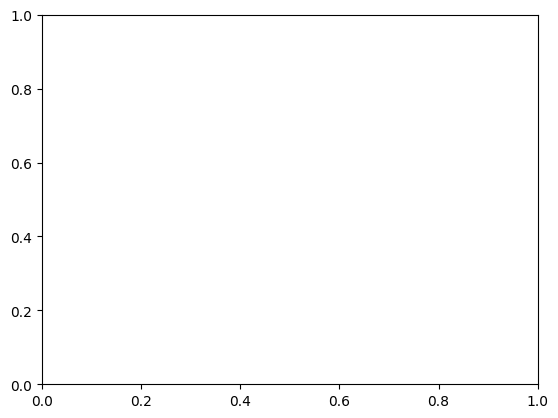

In [12]:
ww_data_comparison = [(data['ww'].values(), f'{count} negative subject(s)') for count, data in neg_user_eers.items()]
ss_data_comparison = [(data['ss'].values(), f'{count} negative subject(s)') for count, data in neg_user_eers.items()]

diff_map = {}

for i in range(2, len(neg_user_eers) + 1):
    windows = neg_user_eers[i]['ww'].keys()
    
    for window in windows:
        if window not in diff_map:
            diff_map[window] = []

        diff_map[window].append(abs(neg_user_eers[i - 1]['ww'][window] - neg_user_eers[i]['ww'][window]))

plot([[diff_map[20000], '20s']], 'Window size (s)', 'EER Difference', '')

# window_diff_ww_data_comparison = [data for window, data in diff_map]
# window_diff_ss_data_comparison = [data for window, data in diff_map]

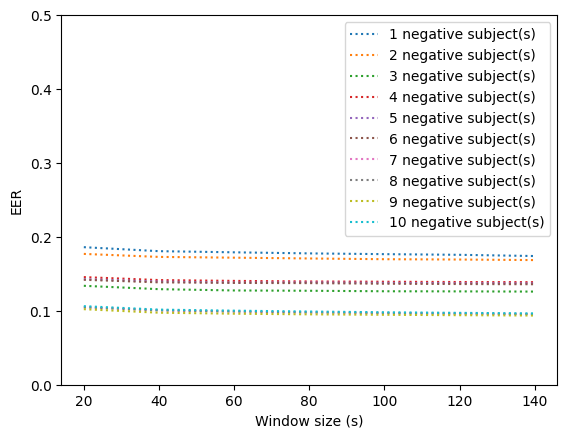

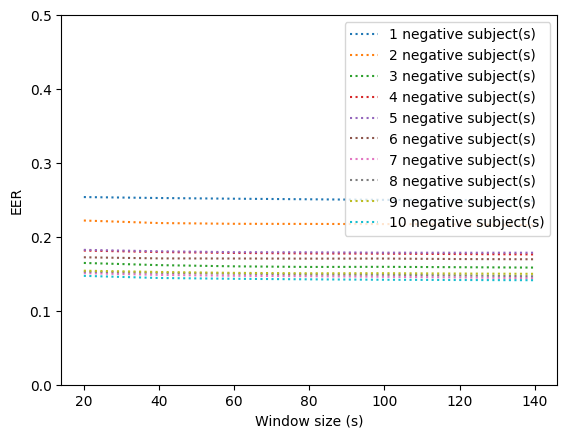

In [12]:
plot(ww_data_comparison, 'Window size (s)', 'EER', '')
plot(ss_data_comparison, 'Window size (s)', 'EER', '')